In [1]:
import os
import pickle
import numpy as np
import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
from matplotlib import gridspec

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 0


/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# load `SpenderQ` model

In [5]:
niter = 3
#models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)
#models, _ = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p5sb1p5.i%i.pt' % niter)
models, _ = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p1sb0p8.hilya.i%i.pt' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


# load batch

In [6]:
ibatch = 0 

wave_obs = np.array(models[0].wave_obs)

#with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
#with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p5sb1p5.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
#with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.hilya.i%i_%i.pkl' % (niter, ibatch), "rb") as f:    
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [7]:
def masking(weights, redshifts, rng):
    if rng == 'above': # above lya
        wlim = np.tile(wave_obs, (len(spec),1)) >  1215 * (1+np.array(redshifts))[:,None]
    elif rng == 'lya': # lya range
        wlim = (np.tile(wave_obs, (len(spec),1)) < 1215 * (1+np.array(redshifts))[:,None]) & (np.tile(wave_obs, (len(spec),1)) > 1026 * (1+np.array(redshifts))[:,None])
    elif rng == 'lyb': # lyb range
        wlim = (np.tile(wave_obs, (len(spec),1)) < 1026 * (1+np.array(redshifts))[:,None])
    val = np.mean(weights[wlim] == 0)
    
    del wlim 
    return val
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

0.2957205370690458 0.4927536440380488 0.6117547822883238


In [8]:
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))
#true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.no_bal_dla.true_cont.npy' % (ibatch))

In [9]:
picca_lya = U.london_picca('LyA')
picca_lyb = U.london_picca('LyB')

# run `SpenderQ`

In [10]:
with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    recon = np.array(models[0].decode(s))

In [11]:
w_recon = np.array(models[0].wave_rest)

# assess performance

/tmp/ipykernel_1149460/912778855.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


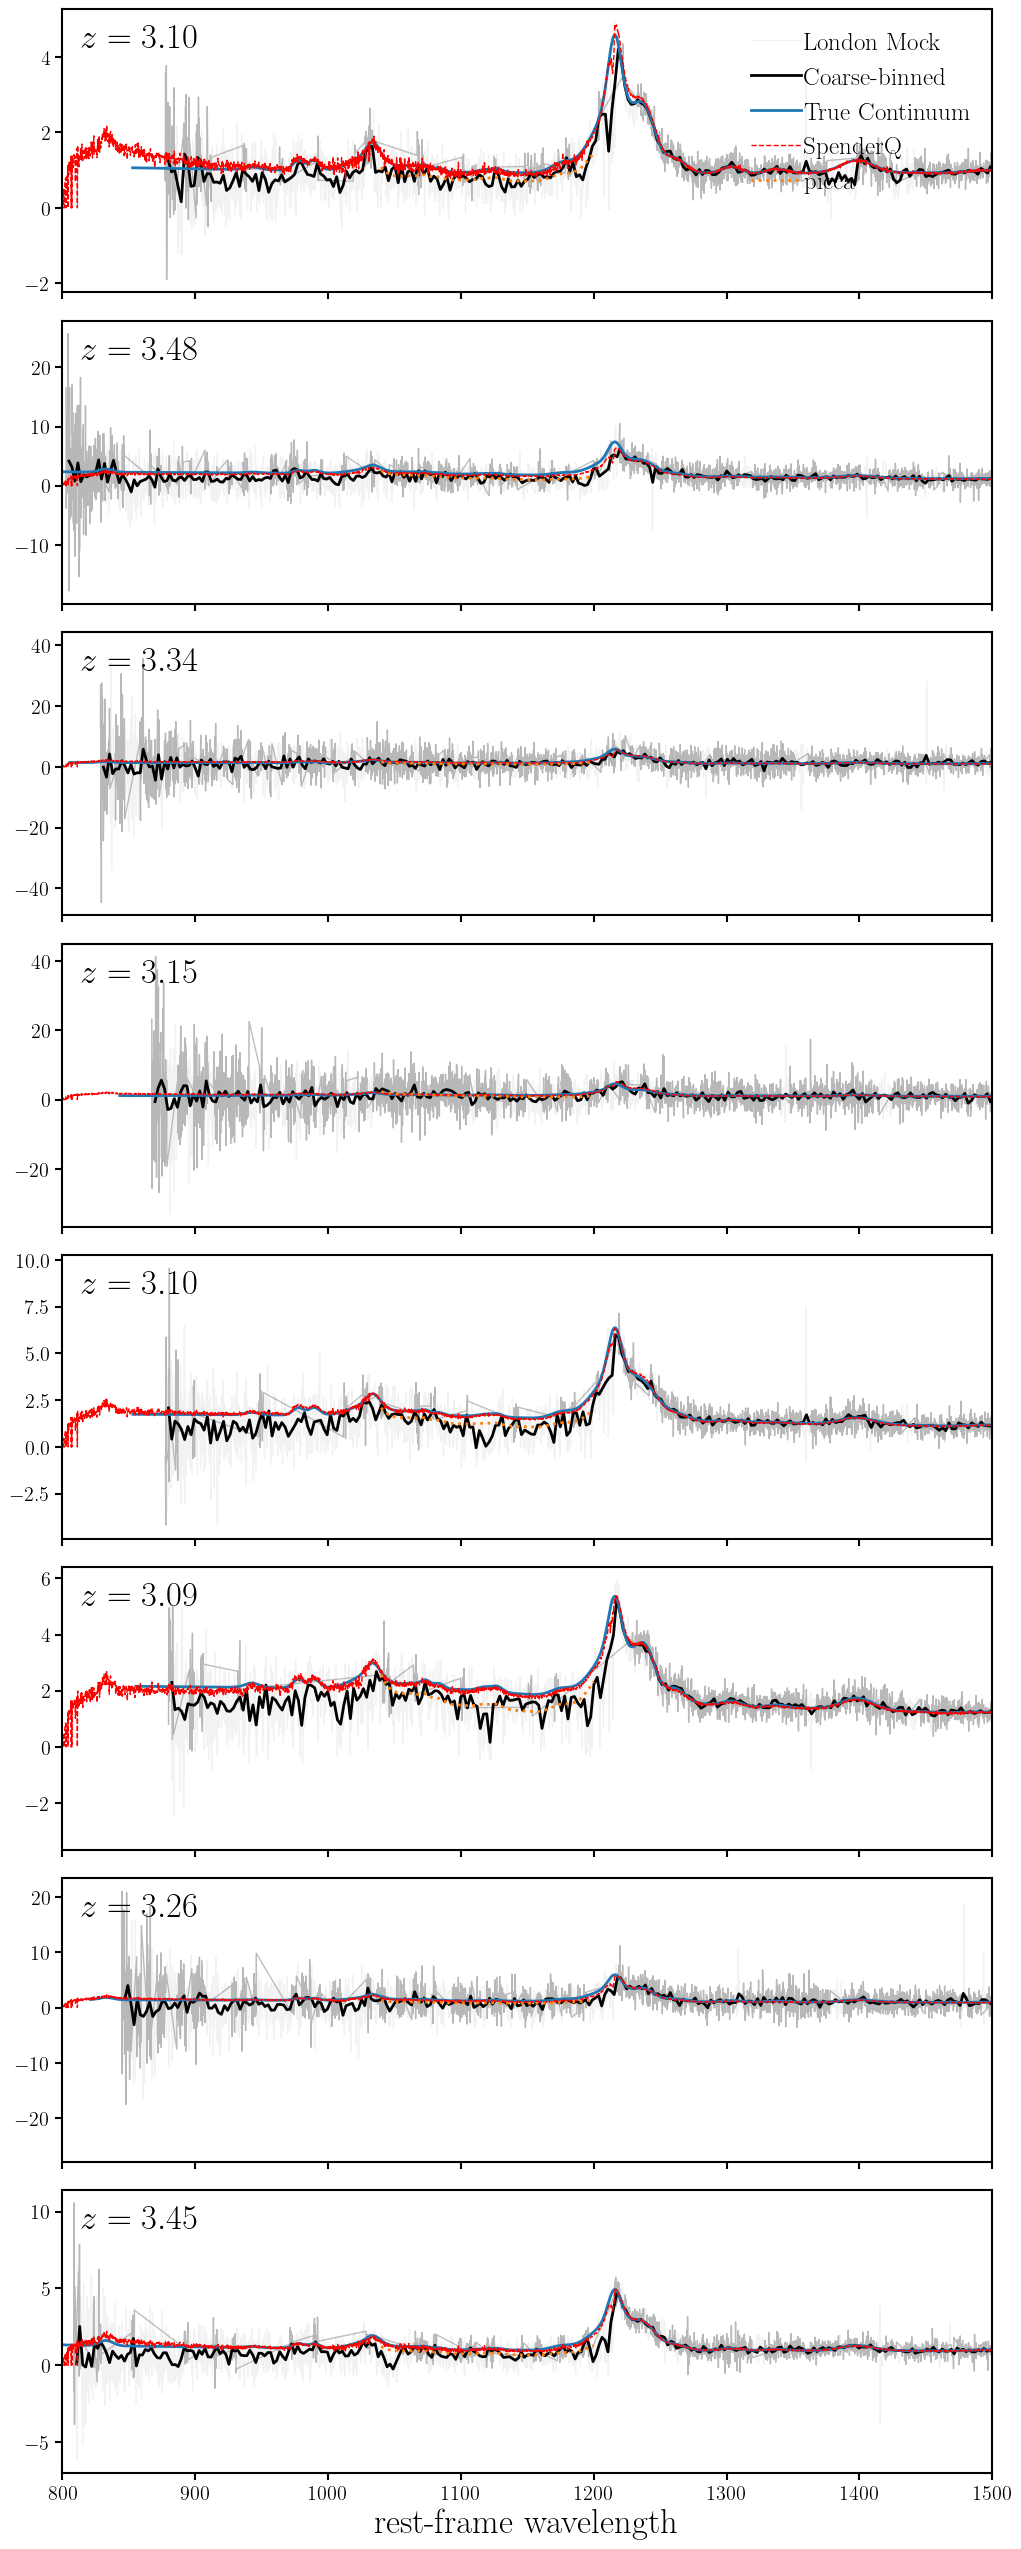

In [12]:
highzs = np.arange(len(z))[z > 3.0][:8]

fig = plt.figure(figsize=(12,4*len(highzs)))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.1, lw=1, label='London Mock')
    sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=2, label='Coarse-binned')

    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # SpenderQ
    sub.plot(models[0].wave_rest, recon[igal], color='r', lw=1, ls='--', label='SpenderQ')
    
    # picca
    spec_picca = picca_lya.get_continuum(int(target_id[igal]))
    if spec_picca is not None:         
        sub.plot(picca_lya.wave_picca, spec_picca/norm[igal], color='C1', lw=2, ls=':', label='picca')

    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_rest[0], 1500.)#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

/tmp/ipykernel_1149460/990519668.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


95
525
393


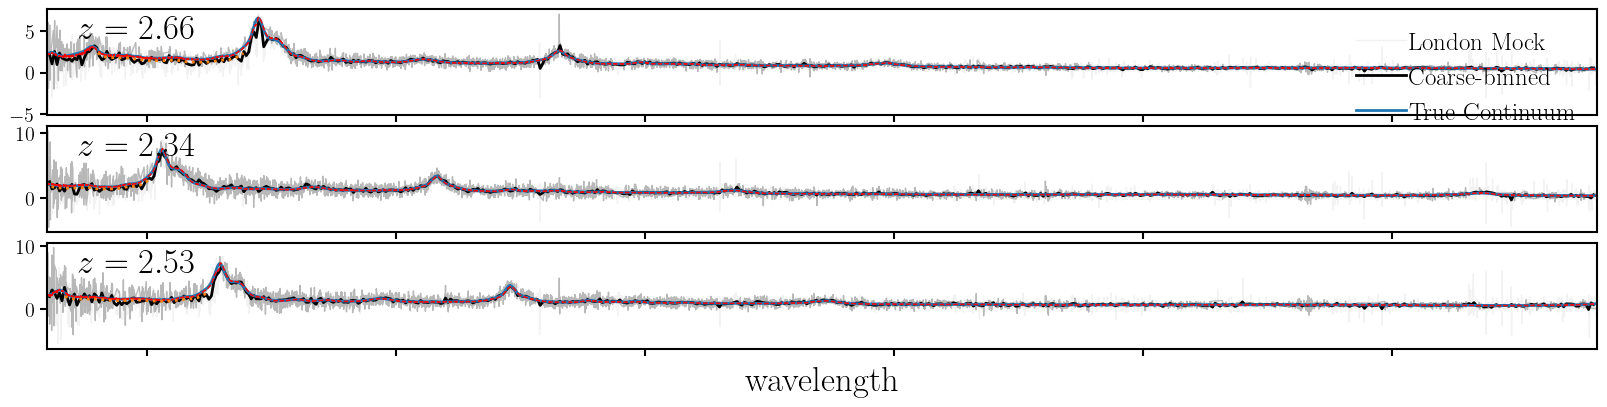

In [13]:
fig = plt.figure(figsize=(20,12))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate([95, 525, 393]): #np.random.choice(np.arange(len(z)), size=3, replace=False)):
    print(igal)
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.1, lw=1, label='London Mock')
    sub.plot((models[0].wave_obs)[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)    

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=2, label='Coarse-binned')

    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest * (1+z[igal]), recon[igal], color='r', lw=1, ls='--', label='spender-qso')
    
    # picca
    spec_picca = picca_lya.get_continuum(int(target_id[igal]))
    sub.plot(picca_lya.wave_picca * (1+float(z[igal])), spec_picca/norm[igal], color='C1', lw=2, ls=':', label='picca')
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
sub.set_xlabel("wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

## quantitative assessment of performance

In [14]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []
dcont_picca_lya, dfcont_picca_lya = [], []
dcont_picca_lyb, dfcont_picca_lyb = [], []

for igal in range(len(z)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+z[igal])) & ((wave_rest_rebin < 9.9e3/float(1+z[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
    
    # picca
    # rebinning for picca
    wlim = (wave_rest_rebin > np.max([1040, 3.6e3/float(1+z[igal])])) & (wave_rest_rebin < 1195)
    
    fpicca = picca_lya.get_continuum(int(target_id[igal]))
    if fpicca is not None: 
        # rebin true continuum
        true_rebin = U.trapz_rebin(
            np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
            np.array(true_cont[igal]/norm[igal]), 
            xnew=wave_rest_rebin[wlim])
        
        # rebin picca
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(
            picca_lya.wave_picca, 
            fpicca, 
            xnew=wave_rest_rebin[wlim])
        
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dcont[wlim] = true_rebin - picca_rebin 
            
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont[wlim] = (true_rebin - picca_rebin)/true_rebin
    else:
        # no picca
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont = np.repeat(-999., len(wave_rest_rebin))
    
    dcont_picca_lya.append(dcont)
    dfcont_picca_lya.append(dfcont)

    # rebinning for picca LyB
    wlim = (wave_rest_rebin > np.max([920, 3.6e3/float(1+z[igal])])) & (wave_rest_rebin < 1020)
    
    fpicca = picca_lyb.get_continuum(int(target_id[igal]))
    if fpicca is not None and np.sum(wlim) > 0: 
        # rebin true continuum
        true_rebin = U.trapz_rebin(
            np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
            np.array(true_cont[igal]/norm[igal]), 
            xnew=wave_rest_rebin[wlim])
        
        # rebin picca
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(
            picca_lyb.wave_picca, 
            fpicca, 
            xnew=wave_rest_rebin[wlim])
        
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dcont[wlim] = true_rebin - picca_rebin 
            
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont[wlim] = (true_rebin - picca_rebin)/true_rebin
    else:
        # no picca
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        
    dcont_picca_lyb.append(dcont)
    dfcont_picca_lyb.append(dfcont)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

dcont_picca_lya = np.array(dcont_picca_lya)
dfcont_picca_lya = np.array(dfcont_picca_lya)

dcont_picca_lyb = np.array(dcont_picca_lyb)
dfcont_picca_lyb = np.array(dfcont_picca_lyb)

negative slope
no fit
no fit
negative slope
no fit
negative slope
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no f

# examine random residuals

[785 324 152 175 179 932]


/tmp/ipykernel_1149460/3831693413.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


Text(0.5, 0, 'rest-frame wavelength [\\r{A}]')

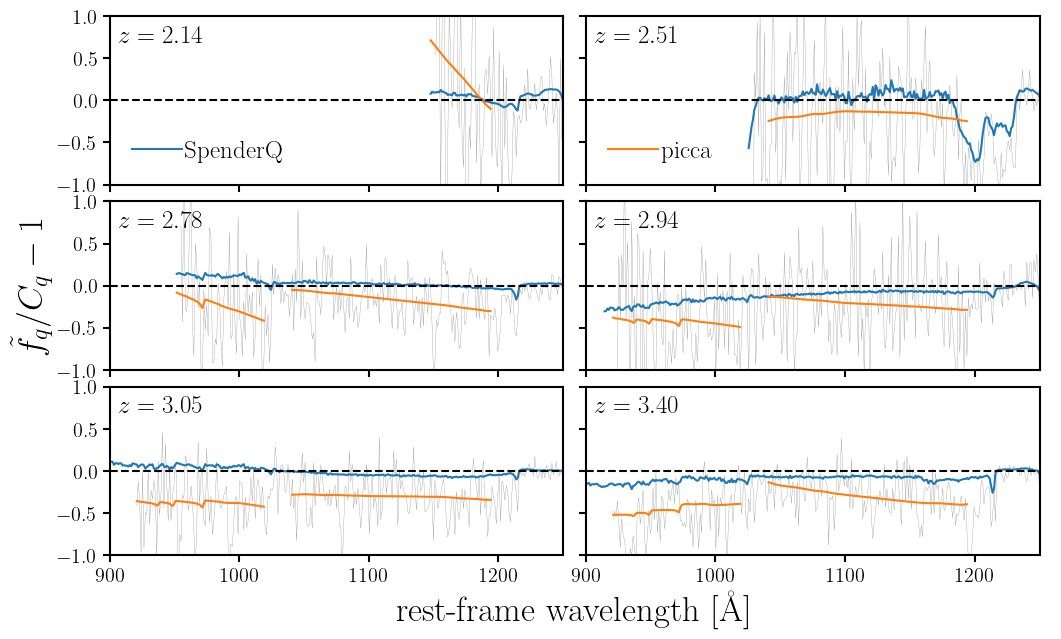

In [15]:
fig = plt.figure(figsize=(12,7))

zbins = np.linspace(2.1, 3.5, 7)
igals = [] 
for i in range(6): 
    igals.append(np.random.choice(np.arange(len(spec))[(z > zbins[i]) & (z < zbins[i+1])], size=1)[0])
igals = np.array(igals)
print(igals)
#igals = igals[np.argsort(np.array(z)[igals])]

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(igals):
    sub = fig.add_subplot(3, 2, ii+1)
    
    wlim = (wave_rest_rebin > np.max([920, 3610/float(1+z[igal])])) & (wave_rest_rebin < np.min([1300, 9800/(1.+np.array(z)[igal])]))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    _spec_rebin = U.trapz_rebin(
            np.array(models[0].wave_obs)/(1.+np.array(z)[igal]), 
            np.array(spec[igal]), 
            xnew=wave_rest_rebin[wlim])
    
    sub.plot(wave_rest_rebin[wlim], (_spec_rebin-true_rebin)/true_rebin, c='k', lw=0.2, alpha=0.5)
    
    
    wlim = (dcont_recon[igal] > -999)
    sub.plot(wave_rest_rebin[wlim], -dfcont_recon[igal][wlim], label=[None, 'SpenderQ'][ii == 0])

    wlim = (dcont_picca_lya[igal] > -999)    
    sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lya[igal][wlim], color='C1', label=[None, 'picca'][ii == 1])
    
    wlim = (dcont_picca_lyb[igal] > -999)
    sub.plot(wave_rest_rebin[wlim], -dfcont_picca_lyb[igal][wlim], color='C1')
    
    sub.axhline(0., color='k', linestyle='--')
    
    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=18, transform=sub.transAxes)

    sub.set_xlim(900., 1250.)#models[0].wave_rest[-1])
    sub.set_xticks([900, 1000, 1100, 1200])
    sub.set_ylim(-1, 1.)
    if ii < 4: sub.set_xticklabels([])
    if ii in [1, 3, 5]: sub.set_yticklabels([])
    if ii in [0, 1]: sub.legend(loc='lower left', fontsize=18, handletextpad=0.1)
    if ii == 2: sub.set_ylabel(r'$\tilde{f}_q/C_q - 1$', fontsize=25)
        
fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)


# aggregated performance

In [16]:
picca_fail_lya = np.all(dcont_picca_lya == -999, axis=1)
print(np.mean(picca_fail_lya))
picca_fail_lyb = np.all(dcont_picca_lyb == -999, axis=1)
print(np.mean(picca_fail_lyb))

0.0517578125
0.7119140625


In [17]:
# spenderq performance on QSO with picca 
dcont_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & ~picca_fail_lya

    if np.sum(has_spectra): 
        dcont_q[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])     
        
# spenderq performance on QSO without picca 
dcont_q_nopicca = np.zeros((len(wave_rest_rebin), 5))
dfcont_q_nopicca = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & picca_fail_lya

    if np.sum(has_spectra): 
        dcont_q_nopicca[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q_nopicca[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])         

# spenderq performance on QSO without picca lyb
dcont_q_nopicca_lyb = np.zeros((len(wave_rest_rebin), 5))
dfcont_q_nopicca_lyb = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & picca_fail_lyb

    if np.sum(has_spectra): 
        dcont_q_nopicca_lyb[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q_nopicca_lyb[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])                 
        
# picca performance on QSO with picca        
dcont_picca_lya_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_picca_lya_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_picca_lya[:,i] != -999.) & ~picca_fail_lya

    if np.sum(has_spectra): 
        dcont_picca_lya_q[i,:] = np.quantile(dcont_picca_lya[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_picca_lya_q[i,:] = np.quantile(dfcont_picca_lya[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])        

# picca lyb performance on QSO with picca lyb
dcont_picca_lyb_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_picca_lyb_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_picca_lyb[:,i] != -999.) & ~picca_fail_lyb

    if np.sum(has_spectra): 
        dcont_picca_lyb_q[i,:] = np.quantile(dcont_picca_lyb[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_picca_lyb_q[i,:] = np.quantile(dfcont_picca_lyb[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])                

Text(0.5, 0, 'rest-frame wavelength')

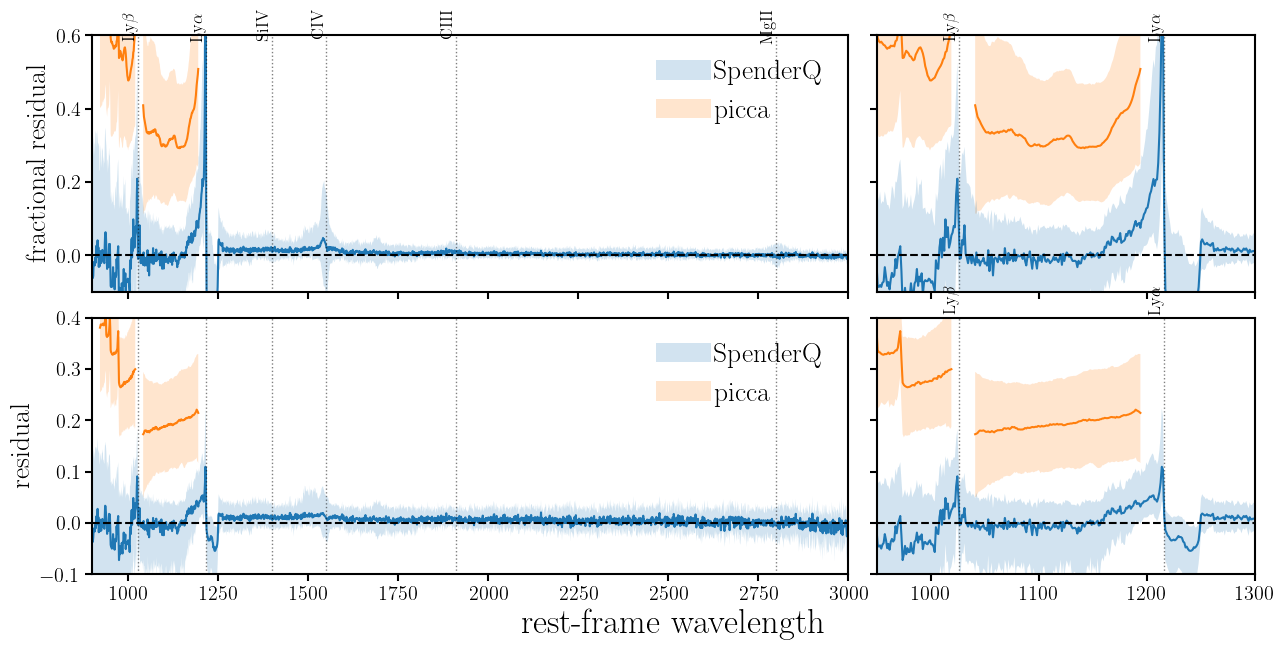

In [18]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

# SpenderQ
sub.fill_between(wave_rest_rebin, dcont_q[:,1], dcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,1][wlim], dcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,2][wlim], color='C1')
# picca LyA
wlim = (dfcont_picca_lya_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lya_q[:,1][wlim], dcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dcont_picca_lya_q[:,2][wlim], color='C1')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.text(1026, 0.66, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.66, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.67, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.67, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.67, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.67, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_xticklabels([])
sub.set_ylabel('fractional residual', fontsize=20)
sub.set_ylim(-0.1, 0.6)

sub = plt.subplot(gs[1])

wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,1][wlim], dcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_lya_q[:,2] > 0)

sub.fill_between(wave_rest_rebin[wlim], dcont_picca_lya_q[:,1][wlim], dcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dcont_picca_lya_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dcont_q[:,1], dcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.66, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.66, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_xticklabels([])
sub.set_ylim(-0.1, 0.6)
sub.set_yticklabels([])

# fractional residual
sub = plt.subplot(gs[2])

# SpenderQ
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')

# picca LyB
wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')
# picca LyA
wlim = (dfcont_picca_lya_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,1][wlim], dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,2][wlim], color='C1')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_ylabel('residual', fontsize=20)
sub.set_ylim(-0.1, 0.4)

sub = plt.subplot(gs[3])

wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_lya_q[:,2] > 0)

sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,1][wlim], dfcont_picca_lya_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lya_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_ylim(-0.1, 0.4)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

# original reconstruction

(-1.5, 4.0)

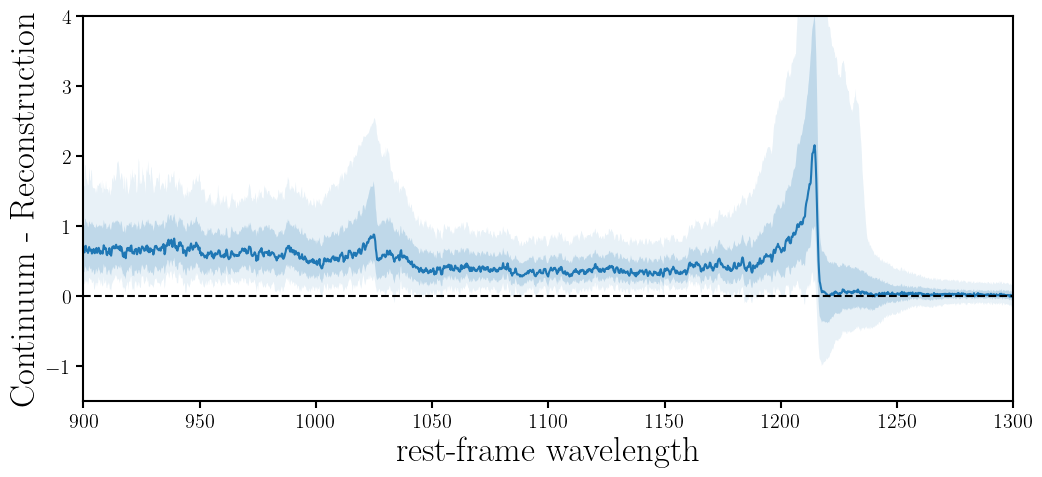

In [35]:
fig = plt.figure(figsize=(12,5))    
sub = fig.add_subplot(111)

sub.fill_between(models[0].wave_rest, dcont_q0, dcont_q4, color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(models[0].wave_rest, dcont_q1, dcont_q3, color='C0', edgecolor='none', alpha=0.2)
sub.plot(models[0].wave_rest, dcont_q2, color='C0')

sub.axhline(0., color='k', linestyle='--')
sub.set_xlabel("rest-frame wavelength", fontsize=25)
sub.set_xlim(900., 1300.)
sub.set_ylabel('Continuum - Reconstruction', fontsize=25)
sub.set_ylim(-1.5, 4.)